In [2]:
import torch
import torch.nn as nn
import tiktoken

In [3]:
gpt_config_124m = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layer": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [4]:
import requests

response = requests.get('https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt')
raw_text = response.text
print(raw_text[:25])

I HAD always thought Jack


In [5]:
len(raw_text)

20479

In [6]:
tokenizer = tiktoken.get_encoding('gpt2')

In [7]:
text1 = "Hello, do you like the tea?"
text2 = "In the sunlight abouve theearth"

text = " <|eos|> ".join((text1,text2))
print(text)
tokens = tokenizer.encode(text, allowed_special={'<|eos|>'})
print(tokens)
print()
tokenizer.decode(tokens)

Hello, do you like the tea? <|eos|> In the sunlight abouve theearth
[15496, 11, 466, 345, 588, 262, 8887, 30, 1279, 91, 68, 418, 91, 29, 554, 262, 19606, 450, 280, 303, 262, 16442]



'Hello, do you like the tea? <|eos|> In the sunlight abouve theearth'

In [8]:
torch.manual_seed(42)
batch_example = torch.randn(2, 5)
print(batch_example)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229],
        [-0.1863,  2.2082, -0.6380,  0.4617,  0.2674]])
tensor([[0.0000, 0.1842, 0.0052, 0.7233, 0.0000, 0.5298],
        [0.0000, 0.0000, 0.0000, 0.2237, 0.0000, 0.7727]],
       grad_fn=<ReluBackward0>)


In [9]:
mean = out.mean(dim=-1, keepdim=True) # dim=-1 refer to last dim
var = out.var(dim=-1, keepdim=True)

print("Mean: ", mean)
print("Var", var)

Mean:  tensor([[0.2404],
        [0.1661]], grad_fn=<MeanBackward1>)
Var tensor([[0.0982],
        [0.0963]], grad_fn=<VarBackward0>)


In [10]:
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim = True)
var = out_norm.var(dim=-1, keepdim = True)
print(mean)
print(var)

tensor([[0.0000e+00],
        [1.4901e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out%num_heads==0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out//num_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
    
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)
    
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    
            # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
    
        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
    
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    
        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
            
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
    
        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
            
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        out_norm = (x-mean)/torch.sqrt(var+self.eps)
        return self.scale * out_norm + self.shift
        

In [13]:
ln = LayerNorm(5)
out = ln(batch_example)
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-1.1921e-08],
        [ 3.2037e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# FeedForward NN

In [15]:
# def GeLU(x):
#     return .5*x*(1+torch*tanh(
#         torch.sqrt(torch.tensor(2.0 / torch.pi))*(x+.044715*torch.pow(x,3))
#     ))

class GELU(nn.Module): 
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return .5*x*(1+torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi))*(x+.044715*torch.pow(x,3))
    ))

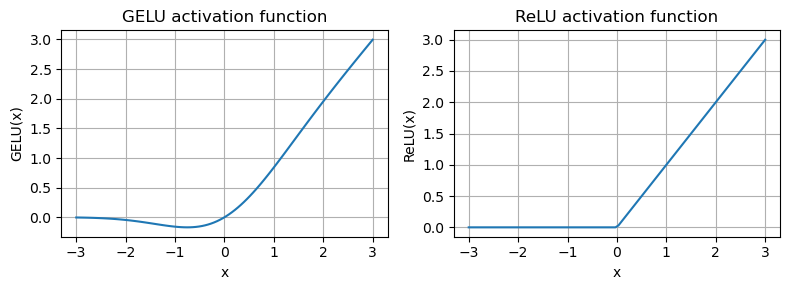

In [16]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            GELU(),
            nn.Linear(4*cfg['emb_dim'], cfg['emb_dim'])
        )
    def forward(self, x):
        return self.layers(x)

In [18]:
ff = FeedForward(gpt_config_124m)
x = torch.randn(2, 3, 768)
op = ff(x)
print(op.shape)

torch.Size([2, 3, 768])


# Residual Connection

In [20]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])
    def forward(self, x):
        for layer in self.layers:
            op = layer(x)
            if self.use_shortcut and x.shape == op.shape:
                x = x + op
            else:
                x = op
        return x

In [21]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[2., 0., -2.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [22]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} gradient is {param.grad.abs().mean().item()}")

In [23]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight gradient is 0.00035526571446098387
layers.1.0.weight gradient is 0.0001255692186532542
layers.2.0.weight gradient is 0.0006820476846769452
layers.3.0.weight gradient is 0.001428114715963602
layers.4.0.weight gradient is 0.005130246747285128


In [24]:
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight gradient is 0.020357703790068626
layers.1.0.weight gradient is 0.05884631350636482
layers.2.0.weight gradient is 0.09979002922773361
layers.3.0.weight gradient is 0.1233186200261116
layers.4.0.weight gradient is 0.6515035033226013


In [25]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias'])
        self.ff = FeedForward(cfg)
        self.norm1 =  LayerNorm(cfg['emb_dim'])
        self.norm2 =  LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        ip = x.clone()
        x = self.norm1(x)

        x = self.att(x)

        x = self.drop_shortcut(x)

        x = ip+x
        
        ip = x.clone()
        x = self.norm2(x)

        x = self.ff(x)

        x = self.drop_shortcut(x)

        x = x+ip
        return x

In [26]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(gpt_config_124m)
op = block(x)
print()
print(op.shape)


torch.Size([2, 4, 768])


In [27]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(12)]
        )
        self.final_norm = nn.LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias = False)
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        # print(in_idx.shape)
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds+pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [28]:
batch_example = torch.randint(gpt_config_124m['vocab_size'], (2, 4))
batch_example

tensor([[20308,   148, 46900,  6624],
        [24359, 14733, 16200, 48499]])

In [29]:
torch.manual_seed(123)
model = GPTModel(gpt_config_124m)
out = model(batch_example)
print("Input batch:\n", batch_example)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[20308,   148, 46900,  6624],
        [24359, 14733, 16200, 48499]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.0778, -0.4861, -0.0606,  ...,  0.7088,  0.5660, -0.6934],
         [-0.4017, -0.4462, -0.2100,  ..., -0.0318,  0.4619, -0.0037],
         [ 0.9630,  0.4658, -0.3201,  ...,  0.1911, -0.3700,  0.3248],
         [ 0.0315, -0.5660,  0.3238,  ...,  0.4954,  0.0469, -0.1438]],

        [[-1.0713, -1.2270,  0.5332,  ..., -0.0138, -0.0318, -0.4353],
         [ 0.3433, -0.3304, -0.6242,  ..., -0.0972,  0.7364, -0.3323],
         [ 1.1776,  1.1702, -0.8074,  ...,  0.6041, -0.4844, -0.2060],
         [-0.6041,  0.3814, -0.2816,  ...,  0.9188,  0.0709,  0.0776]]],
       grad_fn=<UnsafeViewBackward0>)


In [30]:
gpt_config_124m['context_length']

1024

In [167]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        # a = logits[-1, :, :]
        logits = logits[:, -1, :]
        
        probas = torch.softmax(logits, dim=-1)
        
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        
        idx = torch.cat((idx,idx_next), dim=1)

    return idx

In [32]:
start_content = "Hello, I am"
encoded = tokenizer.encode(start_content)
print(encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor)

[15496, 11, 314, 716]
tensor([[15496,    11,   314,   716]])


In [33]:
model.eval()
op = generate_text_simple(model=model, idx= encoded_tensor, max_new_tokens=6, context_size=gpt_config_124m['context_length'])
print(op.shape)
print(op)

torch.Size([1, 10])
tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])


In [85]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 384,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [87]:
text_op = tokenizer.decode(op.squeeze(0).tolist())
print(text_op)

Hello, I am Featureiman Byeswickattribute argue


In [89]:
def text_to_token_ids(text, tokenizer):
    encoder = tokenizer.encode(text, allowed_special = {'|<endoftext>|'})
    encoder_tensor = torch.tensor(encoder).unsqueeze(0)
    return encoder_tensor

def token_ids_to_text(tokens, tokenizer):
    decoder = tokenizer.decode(tokens.squeeze(0).tolist())
    return decoder

In [93]:
start_context = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=gpt_config_124m["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you 320 {" Happy dot cornerstoneratomSTER sob Bordmn


In [94]:
text_to_token_ids(" lot", tokenizer)

tensor([[1256]])

In [95]:
tokenizer.decode([345])

' you'

In [96]:
token_ids_to_text(torch.tensor([16833, 3626, 6100, 345]), tokenizer)

'every effort moves you'

In [97]:
inputs = torch.tensor([[16833, 3626, 6100, 345],   # ["every effort moves you",
                       [40,    1107, 588, 11311]])   #  "I really like chocolate"]

targets = torch.tensor([[3626, 6100, 345, 2651],  # [" effort moves you forward",
                        [1107,  588, 11311, 1256]]) # really like chocolate lot

In [98]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 4, 50257])


In [99]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[38919],
         [12468],
         [11140],
         [20959]],

        [[16692],
         [29294],
         [ 2221],
         [44062]]])


In [100]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you forward
Outputs batch 1:  OstWork Search 320


In [101]:
logits_flat = logits.flatten(0,1)
target_flat = targets.flatten()

print(logits.shape)
print(targets.shape)
print(logits_flat.shape)
print(target_flat.shape)

torch.Size([2, 4, 50257])
torch.Size([2, 4])
torch.Size([8, 50257])
torch.Size([8])


In [102]:
loss = torch.nn.functional.cross_entropy(logits_flat, target_flat)
loss

tensor(10.9016)

In [103]:
perplexity = torch.exp(loss)
perplexity

tensor(54262.1250)

# Data-Loading and Model Learning

In [105]:
import requests

response = requests.get('https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt')
raw_text = response.text

tokenizer = tiktoken.get_encoding('gpt2')

In [106]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))

print("Char: ", total_characters)
print("tokens: ", total_tokens)

Char:  20479
tokens:  5145


In [400]:
import pandas as pd

df = pd.read_csv("/Users/shubham/Desktop/Projects/Text_Summarizer/NewsDataset.csv")

In [420]:
df.head()

,Summary,Text
0,Celeb chef Anthony Bourdain wins multiple Emmy...,"Celebrity chef Anthony Bourdain, who passed aw..."
1,"Clearly something is wrong with US, says JPMor...",World's most valuable bank JPMorgan Chase's CE...
2,Two more allegedly commit suicide over Maratha...,Two more people have allegedly committed suici...
3,Must curb hate speeches during poll campaigns:...,A group of former chief election commissioners...
4,PNB to block all Maestro debit cards from July 31,Punjab National Bank (PNB) Maestro debit card ...


In [430]:
import string
import re
punch = string.punctuation
punch

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [426]:
def summ(text):
    new_text = re.sub(r"'s\b", "is", text)
    new_text = re.sub(r'<.*?>',' ',new_text)
    new_text = re.sub(r'https?://\S+|www\.\S+','',new_text)
    new_text = re.sub('@[A-Za-z0-9]+',' ',new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
#     new_text = re.sub(r'\b(\w+)(?:\W+\1\b)+',r"\1", new_text)
    new_text = re.sub(r'(.)\1{2,}', r'\1\1', new_text)
    new_text.translate(str.maketrans('','',punch))

    newString= ''
    for i in new_text.split():
        if len(i)>1:
            newString=newString+i+' '
    return newString

In [422]:
dt = pd.DataFrame()

In [440]:
dt['summ'] = df['Summary'].apply(summ)
dt['text'] = df['Text'].apply(summ)

In [486]:
text = ""
# train_data = ""
# val_data = ""
for i, row in dt[:len(dt)//4].iterrows():
    text += row.values[0]+ " "+row.values[1]
    # train_data += row.values[1]
    # val_data += row.values[0]

In [487]:
total_characters = len(text)
total_tokens = len(tokenizer.encode(text))

print("Char: ", total_characters)
print("tokens: ", total_tokens)

In [ ]:
# print()

In [462]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text))
train_data = text[:split_idx]
val_data = text[split_idx:]

In [490]:
len(train_data), len(val_data) #38179433

(8969890, 1551718)

In [492]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [494]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [496]:
torch.manual_seed(42)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=64,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=64,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [498]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [500]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 256]) torch.Size([64, 256])
torch.Size([64, 25

In [502]:
train_tokens = 0
for inputs_batch, target_batch in train_loader:
    train_tokens += inputs_batch.numel()

val_tokens = 0
for inputs_batch, target_batch in val_loader:
    val_tokens += inputs_batch.numel()

print(train_tokens)
print(val_tokens)

1687552
310528


In [504]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    # print(logits.flatten(0, 1).shape)
    # print(target_batch.flatten().shape)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader)==0:
        return float("nan")
        
    elif num_batches is None:
        num_batches = len(data_loader)
        
    else:
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss

        else:
            break
    return total_loss / num_batches

In [509]:
if torch.cuda.is_available():
   device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#    device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

Using cpu device.


In [511]:
model

GPTModel(
  (tok_emb): Embedding(50257, 384)
  (pos_emb): Embedding(256, 384)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=384, out_features=384, bias=False)
        (W_key): Linear(in_features=384, out_features=384, bias=False)
        (W_value): Linear(in_features=384, out_features=384, bias=False)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [513]:
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=1)
    # val_loss = calc_loss_loader(val_loader, model, device, num_batches=1)

print("Training loss:", train_loss)
# print("Validation loss:", val_loss)

Training loss: tensor(10.7881)


In [517]:
def evaluate_model(train_loader, val_loader, model, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    return train_loss, val_loss

# Training Model

In [519]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, epoches, 
                      eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, token_seens = [], [], []
    global_step=1
    for epoch in range(epoches):
        model.train()
        
        for train_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(train_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            token_seen+=train_batch.numel()
            global_step +=1

            if global_step%eval_freq==0:
                train_loss, val_loss =evaluate_model(train_loader, val_loader, model, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                token_seens.append(token_seens)
                print(f"For the epoch {epoch}, {global_step}: train_loss: {train_loss:.4f} and val_loss: {val_loss:.4f}")

        # start_context = "Every effort moves you"
        model.eval()
        token_ids = generate_text_simple(
            model=model,
            idx=text_to_token_ids(start_context, tokenizer),
            max_new_tokens=50,
            context_size=gpt_config_124m["context_length"]
        )
        
        print("Output text: ", token_ids_to_text(token_ids, tokenizer).replace("\n", " "))
        print()
    return train_losses, val_losses, token_seens

In [203]:
import time
start_t = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.08)

start_context = "Every effort moves you"
train_losses, val_losses, token_steps = train_model_simple(model, train_loader, val_loader, optimizer, device, 31, 
                5, 5, start_context, tokenizer)

time_taken = (time.time() - start_t)/60
print(f"time taken is : {time_taken:.2f}")

For the epoch 0 train_loss: 9.389822006225586 and val_loss: 9.481074333190918
Output text:  Every effort moves you, the, the, the,, the the,,, the, the, the,,, the the,,,, the, the,, the the,, the,,, the, the the, the,, the the

For the epoch 1 train_loss: 8.41596508026123 and val_loss: 8.597633361816406
For the epoch 1 train_loss: 7.382205009460449 and val_loss: 7.696166038513184
Output text:  Every effort moves you, the, the, the,, the the,,, the,, the,,,,, the,,,, the, the,, the,,,,,,, the, the,,,,, the,

For the epoch 2 train_loss: 6.581667423248291 and val_loss: 7.050644397735596
For the epoch 2 train_loss: 6.105190277099609 and val_loss: 6.703143119812012
Output text:  Every effort moves you, the, the, the, I.                                         

For the epoch 3 train_loss: 5.528920650482178 and val_loss: 6.579864978790283
For the epoch 3 train_loss: 5.329677104949951 and val_loss: 6.414705276489258
Output text:  Every effort moves you the he was, and the, and I had, and I h

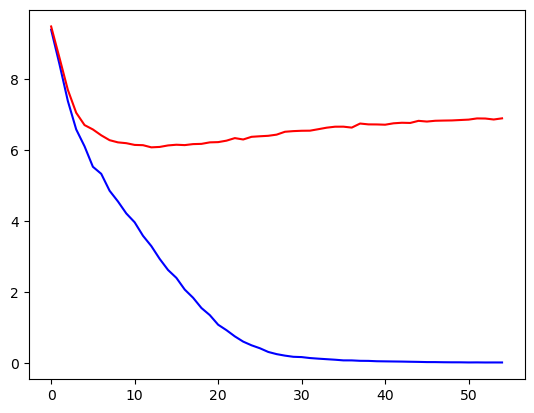

In [207]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(train_losses)), train_losses, 'b')
plt.plot(np.arange(len(train_losses)), val_losses, 'r')

In [329]:
idx = [0.1, 0.4, 0.2, 0.3, 0.1]

def generate_text_simple(idx, temp):
    for _ in range(1):

        # with torch.no_grad():
        #     logits = model(idx_cond)

        logits = torch.tensor(idx)
        scaled_logits = logits/(temp)
        
        probas = torch.softmax(scaled_logits, dim=-1)
        
        idx_next = torch.multinomial(probas, num_samples=1)

        # idx = torch.cat((idx,idx_next), dim=1)

    return idx_next

generate_text_simple(idx, 0.08)

tensor([3])

In [275]:
def decoding_using_temperature_scaling(model, temp, idx, max_new_tokens, context_size):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        scaled_logits = logits/(temp)
        
        probas = torch.softmax(scaled_logits, dim=-1)
        
        idx_next = torch.multinomial(probas, num_samples=1)

        idx = torch.cat((idx,idx_next), dim=1)

    return idx

In [331]:
tokens = decoding_using_temperature_scaling(model, 0.9, text_to_token_ids(start_context, tokenizer),
                                           10, 124)
token_ids_to_text(tokens, tokenizer).replace("\n", " ")

'Every effort moves you?"  "Yes--quite," she said'

In [375]:
def decoding_using_temp_scaling_and_topk(model, temp, k, idx, max_new_tokens, context_size, eos_idx=None):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        if k is not None:
            values, _ = torch.topk(logits, k=k)
            logits = torch.where(logits<values[:, -1], torch.tensor(float("-inf")).to(logits.device), logits)

        if temp>0.0:
            logits = logits/(temp)
        
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)

        else:
            idx_next = torch.argmax(probas, dim=-1, keepdim=True)
            
        if idx_next==eos_idx:
            break
        idx = torch.cat((idx,idx_next), dim=1)

    return idx

In [383]:
token_ids = decoding_using_temp_scaling_and_topk(model, .8, 3, 
                                    idx = text_to_token_ids("Here down we", tokenizer),
                                    max_new_tokens=15, 
                                    context_size = GPT_CONFIG_124M["context_length"])

token_ids_to_text(token_ids, tokenizer)

'Here down we if I\'d never touched a brush."\n\nAnd his tone told me'

In [393]:
model.parameters()

<generator object Module.parameters at 0x3e5ccece0>

# Saving and loading model, optimizer

In [398]:
torch.save({
    "model_state_dict":model.state_dict(), 
    "optimizer_state_dict":optimizer.state_dict()}, 
    "model.pth"
)

In [ ]:
# loading

checkpoint = torch.load("model_and_optimizer.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(lr=4e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])